<a href="https://colab.research.google.com/github/TheAmirHK/Financial-market-price-analysis-and-prediction/blob/main/Stock%20price%20forecasting_ARIMA%20Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime
from datetime import datetime, date, timedelta
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
from statsmodels.tsa.ar_model import AutoReg

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , mean_absolute_percentage_error, r2_score, mean_absolute_error
from tqdm import tqdm
# For warnings suppression
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# The stocks to be analyzed !
stock = ["AAPL"]

# define the number of year to be studied
NYears = 5

# Define the time period of study
end = datetime.today()
start = end - timedelta(days = NYears*365)
# Download stock data
data = pdr.get_data_yahoo(stock, start, end)

<p align="justify">
The ARIMA (AutoRegressive Integrated Moving Average) model is a popular and powerful time series analysis and forecasting method. It combines autoregressive (AR), differencing (I), and moving average (MA) components to capture different aspects of a time series data.
The ARIMA model is defined by three main parameters:</p>


1.   p (order of autoregression): The number of lag observations included in the model.
2.   d (degree of differencing): The number of times the raw observations are differenced to make the time series stationary.
3.   q (order of moving average): The size of the moving average window.
<p align="justify">
The general form of an ARIMA model is represented as ARIMA(p, d, q). Here's a brief overview of each component:
Autoregressive (AR) component (p): This captures the relationship between an observation and a number of lagged observations.
Integrated (I) component (d): This represents the differencing of raw observations to make the time series stationary.
Moving Average (MA) component (q): This incorporates the dependency between an observation and a residual error from a moving average model.</p>


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1130
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -2579.229
Date:                Thu, 30 Nov 2023   AIC                           5164.457
Time:                        10:41:37   BIC                           5179.545
Sample:                             0   HQIC                          5170.158
                               - 1130                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0552      0.023     -2.415      0.016      -0.100      -0.010
ar.L2         -0.0322      0.023     -1.378      0.168      -0.078       0.014
sigma2         5.6472      0.160     35.313      0.0

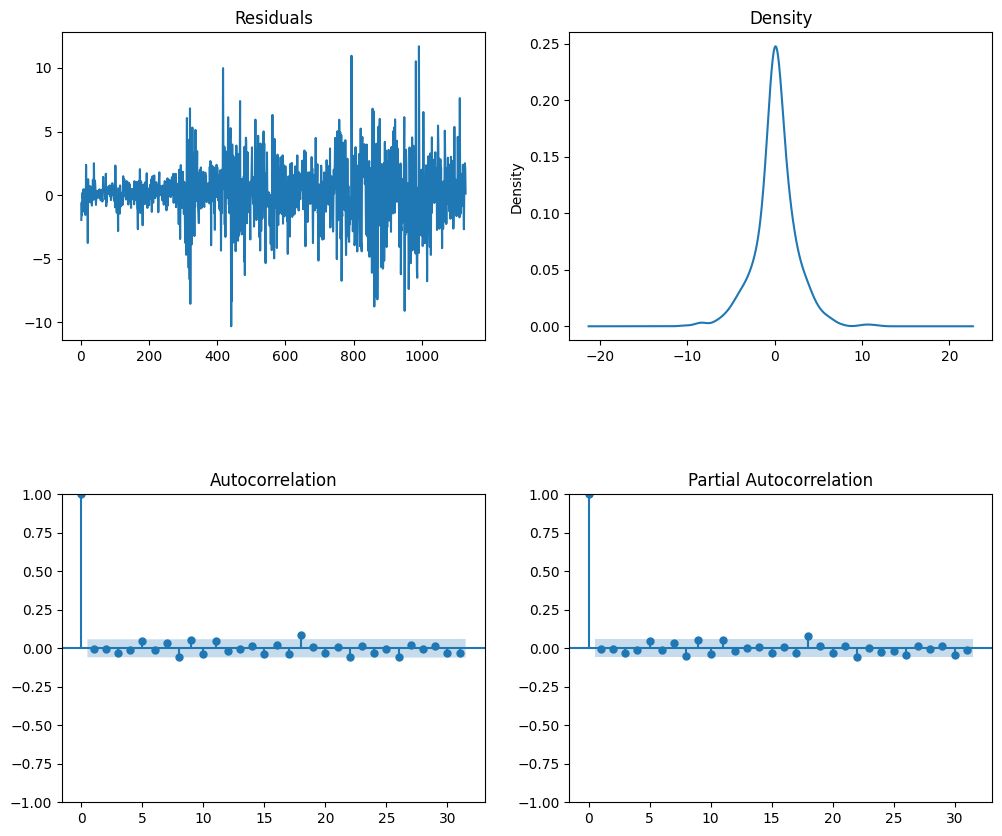

count    1129.000000
mean        0.127501
std         2.374026
min       -10.307759
25%        -0.872569
50%         0.135979
75%         1.244946
max        11.697800
dtype: float64


In [13]:
# Autocorrelation test and transforming non-stationary time-series to stationary using differencing for ARIMA
def diff_data(data, plot=None):
    adf_test = adfuller(data)
    #print(f'p-value: {adf_test[1]}')
    count_diff = 0
    while adf_test[1]>0.05 : # continue differences till p-value is less than 5 percents
      df_train_diff = data.diff().dropna()
      count_diff += 1
      adf_test = adfuller(df_train_diff)
    if plot is not None:
        df_train_diff.plot()
        acf_diff = plot_acf(df_train_diff)
        pacf_diff = plot_pacf(df_train_diff)
    return count_diff


# Define train and valid data
def split_data (data , test_size= None, split_date=None):

    input = pd.DataFrame(data)
    input["date"]= input.index
    input = input.set_index('date')
    input = input.reset_index(drop=True)

    if ((split_date is not None) and (test_size is None)):
      split_date = pd.Timestamp(split_date)
      train  = input[: split_date].dropna()
      valid = input[split_date : ].dropna()

    elif ((split_date is None) and (test_size is not None)):
      train, valid = train_test_split(input, test_size=test_size, shuffle=False)

    return train, valid

# Evaluate the dependency between an observation and a residual error from a moving average model applied to lagged observations
def analyse_res(data):
    residuals = data.resid[1:]
    fig, ax = plt.subplots(2,2,figsize=(12, 10))
    plt.subplots_adjust(hspace=0.5)
    residuals.plot(title='Residuals', ax=ax[0,0])
    residuals.plot(title='Density', kind='kde', ax=ax[0,1])
    acf_res = plot_acf(residuals, ax=ax[1,0])
    pacf_res = plot_pacf(residuals, ax=ax[1,1])
    plt.show()
    print(residuals.describe())
    return

train_set = data["Adj Close"]
train, valid = split_data (train_set , test_size= 0.1, split_date=None)
n_d = diff_data(train)
arima_model = ARIMA(train, order=(2,n_d,0))
model_fit = arima_model.fit()
print(model_fit.summary())
analyse_res(model_fit)

In [5]:
# ARIMA Walk Forward Validation for checking the validity of the model
test_size = 0.1
train_size = np.int(len(train_set) *(1-test_size))
last_index = len(train_set)
predictions = list()
valids = list()

for i in tqdm(range(train_size, last_index)):
    train, valid = train_set[0:i], train_set[i:i+1]
    d = diff_data(train)
    model = ARIMA(train, order=(2,d,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output
    predictions.append(yhat)
    valids.append(valid)

100%|██████████| 126/126 [01:04<00:00,  1.96it/s]


ARIMA method MAPE = 0.009 


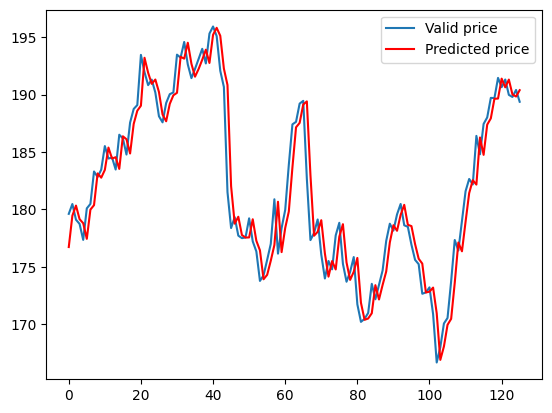

In [6]:
# evaluate model using MAPE score
ARIMA_MAPE = mean_absolute_percentage_error(valids, predictions)
print("ARIMA method MAPE = %0.3f "%ARIMA_MAPE)
# plot predictions against actual outcomes
plt.plot(valids, label="Valid price")
plt.plot(predictions, color='red', label ="Predicted price")
plt.legend()
plt.show()

100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


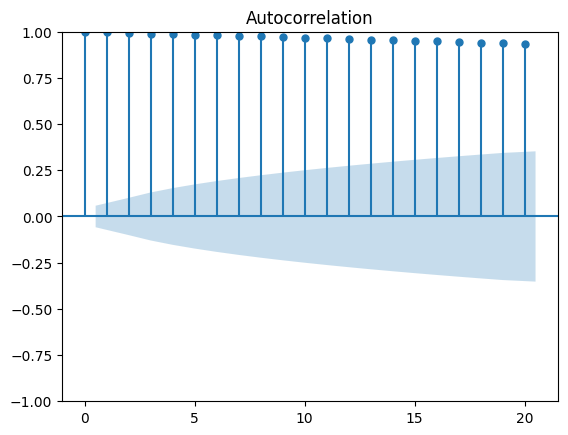

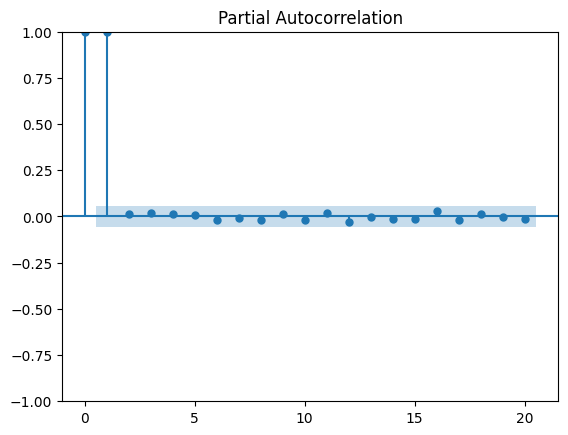

     lag  window       MSE       MPE       MAE
65  10.0    10.0  4.909595  0.009229  1.671995


In [167]:
""" this code can find the optimal value for lag of the data by intoducing the train and test set and defing the maximum lag by the user"""

train_set = data["Adj Close"]
train, valid = split_data (train_set , test_size= 0.1, split_date=None)
def find_optimal_lag(train, valid, lags):
    train_set = train.values
    valid_set = valid.values
    lag_list = list()
    window_list = list()
    mse_list = list()
    mae_list = list ()
    mpe_list = list()
    for i in tqdm(range(lags)):
        for j in range(lags):
          if j <= i:
            # train autoregression
            model = AutoReg(train, lags = i)
            model_fit = model.fit()
            window = j
            coef = model_fit.params

            # walk forward over time steps in test
            history = train_set[len(train_set)-window:]
            history = [history[i] for i in range(len(history))]

            predictions = list()

            for t in range(len(valid_set)):
                length = len(history)
                lag = [history[i] for i in range(length-window,length)]
                yhat = coef[0]
                for d in range(window):
                    yhat += coef[d+1] * lag[window-d-1]
                obs = valid_set[t]
                predictions.append(yhat)
                history.append(obs)


            mse = mean_squared_error(valid, predictions)
            mpe = mean_absolute_percentage_error(valid, predictions)
            mae = mean_absolute_error(valid, predictions)
            mse_list.append(mse)
            mpe_list.append(mpe)
            mae_list.append(mae)
            lag_list.append(i)
            window_list.append(j)
    result = pd.DataFrame([lag_list,window_list,mse_list,mpe_list, mae_list ]).T
    result.columns = ['lag','window','MSE','MPE', 'MAE' ]
    optimal = result[result["MPE"] == result["MPE"].min()]


    # Plot the ACF and PACF
    plot_acf(train, lags=lags)
    plot_pacf(train, lags=lags)
    plt.show()
    print (optimal)

    return  optimal

optimal = find_optimal_lag(train, valid, 20)

MSE: 4.910 
MAE: 1.672 
MAPE: 0.923 %


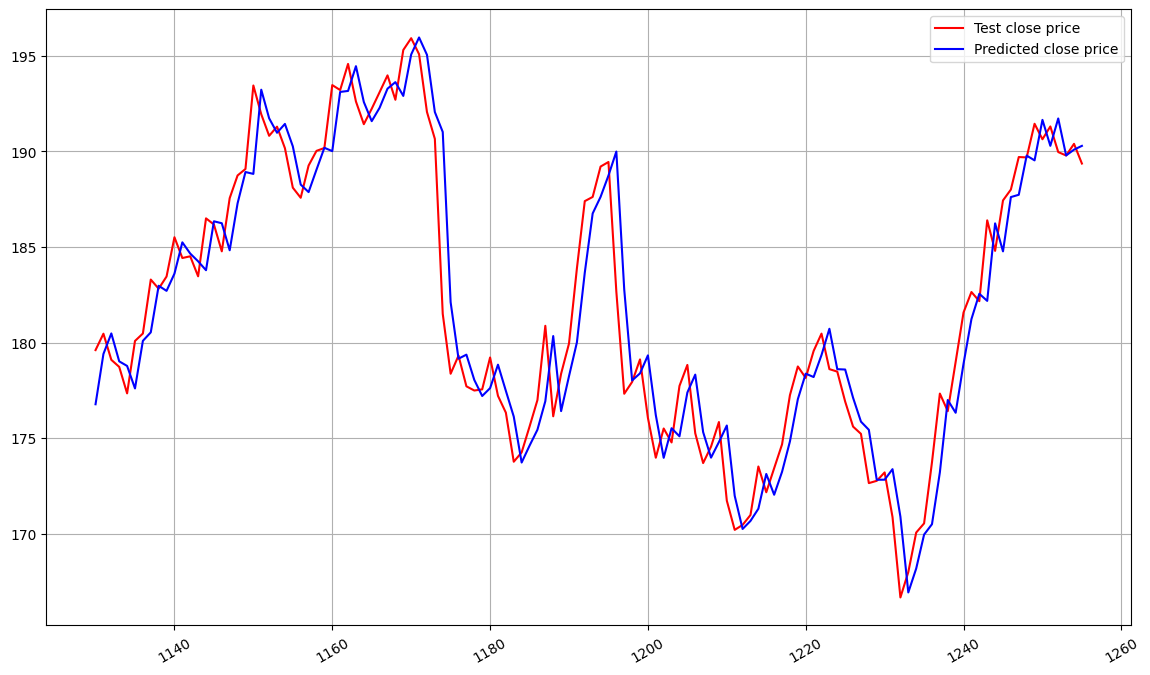

In [165]:
## This code fit an autoregression model using the optimal lag and evaluate the model accuarcy
train_set = data["Adj Close"]
train, valid = split_data (train_set , test_size= 0.1, split_date=None)

train_set = train.values
valid_set = valid.values

# train autoregression
model = AutoReg(train, lags = np.int(optimal["lag"].values))
model_fit = model.fit()
window = np.int(optimal["window"].values)
coef = model_fit.params

# walk forward over time steps in test
history = train_set[len(train_set)-window:]
history = [history[i] for i in range(len(history))]

predictions = list()

for t in range(len(valid_set)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = valid_set[t]
    predictions.append(yhat)
    history.append(obs)

plt.figure(figsize=(14,8))
plt.plot(valid.index, valid, color='red', label='Test close price')
plt.plot(valid.index, predictions, color='blue', label='Predicted close price')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()

mse = mean_squared_error(valid, predictions)
print('MSE: %0.3f '%(mse))
mae = mean_absolute_error(valid, predictions)
print('MAE: %0.3f '%(mae))
mpe = mean_absolute_percentage_error(valid, predictions)
print('MAPE: %0.3f'%(mpe*100),"%")